# Advanced Explorative Data Analysis
In this notebook we do explore the cleaned data set. Furthermore, we investigate the generated "ELO score" and draw some conclusions based on the player activity.

In [1]:
# Import necessary libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
# Import data and remove NaNs (races which weren't finished)
data = pd.read_csv("data/cleaned_data/races_cleaned.csv")
data[["race_created", "race_driven"]] = \
    data[["race_created", "race_driven"]].astype("datetime64")
data.dropna(inplace=True)


In [3]:
# Parameter
title_fontsize = 25
axis_fontsize = 20
legend_size = 20
tick_label_fontsize = 15


## 1 Fuel consumption
### 1.1 Distribution
We observe predominaely a fuel consumption $\leq 5$ However, there is a local maximum at approximately 35 as well. Although it is much weaker.

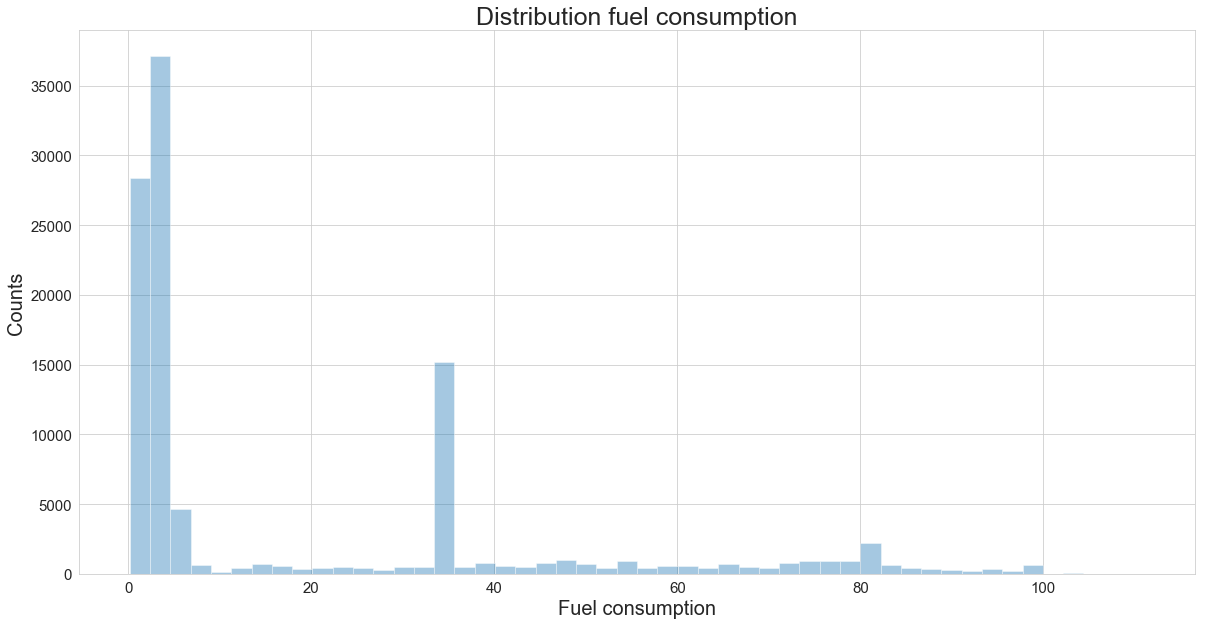

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(data["fuel_consumption"], kde=False)
plt.title("Distribution fuel consumption", fontsize=title_fontsize)
plt.xlabel("Fuel consumption", fontsize=axis_fontsize)
plt.ylabel("Counts", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

### 1.2 What effects fuel consumption?
We might ask ourselves how fuel consumption relates to other variables. In particular if it is affected by weather or money. 
However, this does not seem to be the case as is shown in the following scatter plots.

Note: To keep memory consumption to a minimum we consider only a subset of the given data.

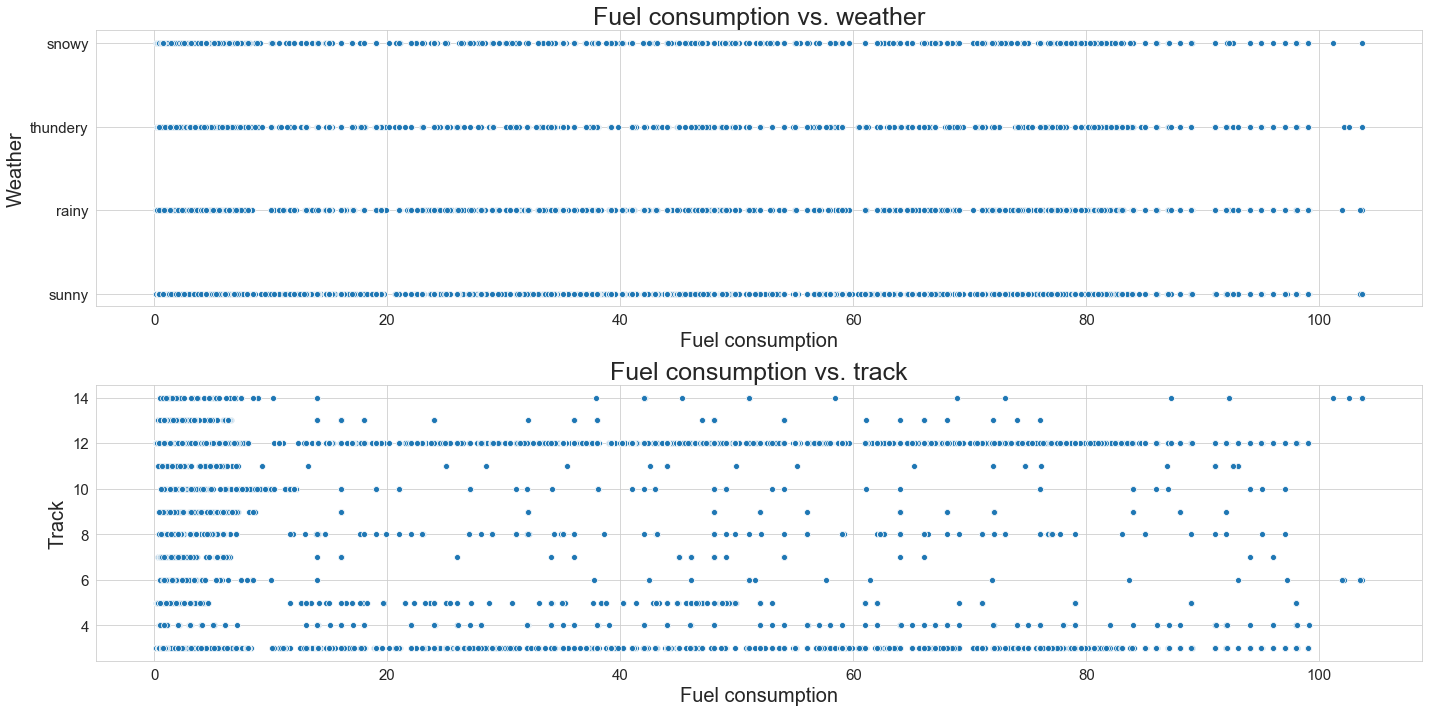

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sample = data.sample(frac=0.3, random_state=42)

sns.scatterplot(x="fuel_consumption", y="weather", data=sample, ax=ax[0])
ax[0].set_title("Fuel consumption vs. weather", fontsize=title_fontsize)
ax[0].set_xlabel("Fuel consumption", fontsize=axis_fontsize)
ax[0].set_ylabel("Weather", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

sns.scatterplot(x="fuel_consumption", y="track_id", data=sample, ax=ax[1])
ax[1].set_title("Fuel consumption vs. track", fontsize=title_fontsize)
ax[1].set_xlabel("Fuel consumption", fontsize=axis_fontsize)
ax[1].set_ylabel("Track", fontsize=axis_fontsize)
ax[1].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

fig.tight_layout()
plt.show()

Furthermore, we observe that only one value is given per race. This indicates that this variable might be a property of the race itself instead of an observed quantity of that race. Otherwise we would expect one value for each the opponent and challenger.

## 2 Money

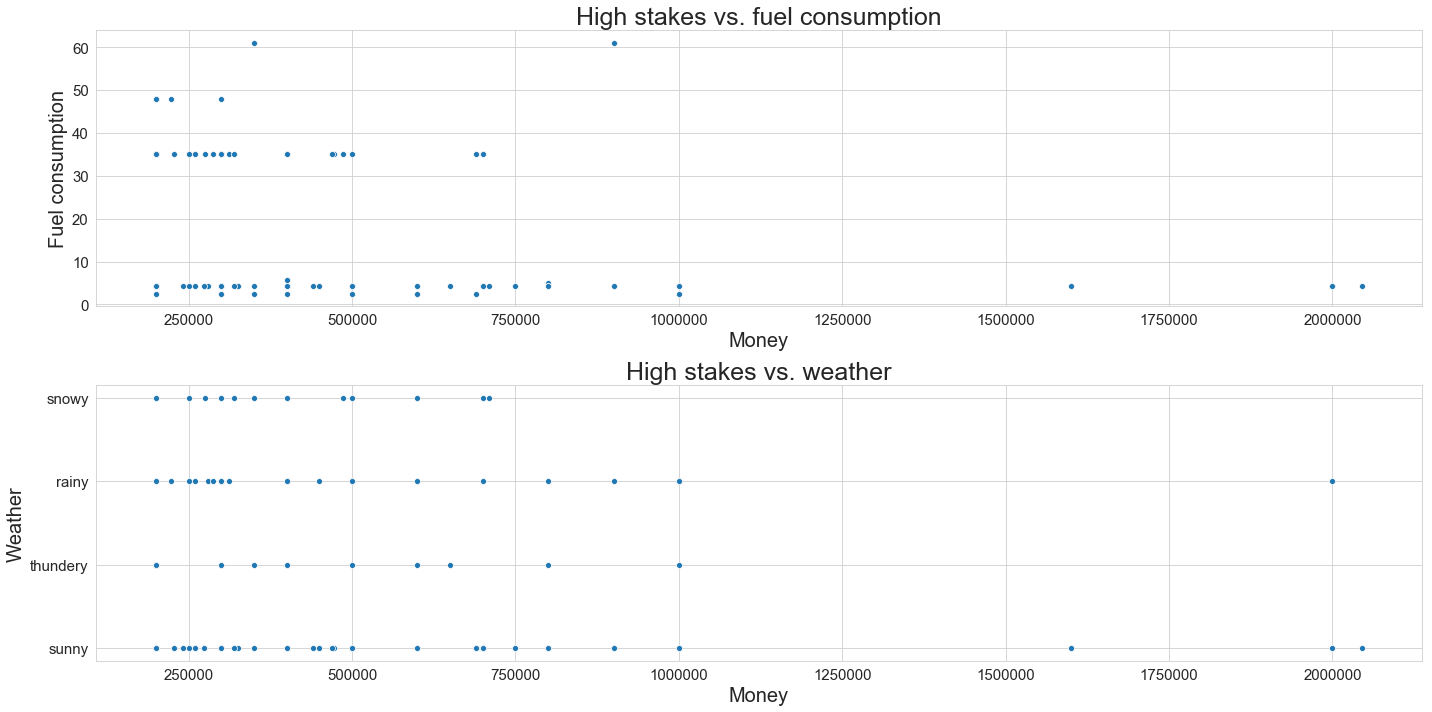

In [9]:
df_money = data.loc[data.money>=200000]  # consider only high stakes

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.scatterplot(x="money", y="fuel_consumption", data=df_money, ax=ax[0])
ax[0].set_title("High stakes vs. fuel consumption", fontsize=title_fontsize)
ax[0].set_xlabel("Money", fontsize=axis_fontsize)
ax[0].set_ylabel("Fuel consumption", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)


sns.scatterplot(x="money", y="weather", data=df_money, ax=ax[1])
ax[1].set_title("High stakes vs. weather", fontsize=title_fontsize)
ax[1].set_xlabel("Money", fontsize=axis_fontsize)
ax[1].set_ylabel("Weather", fontsize=axis_fontsize)
ax[1].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

fig.tight_layout()
plt.show()

High stakes seem to be independent of both weather and fuel consumption. Furthermore, the low quantity of high stakes rules out any connection to tracks. This leads to the conclusion that it might be "freely" chosen by the players.

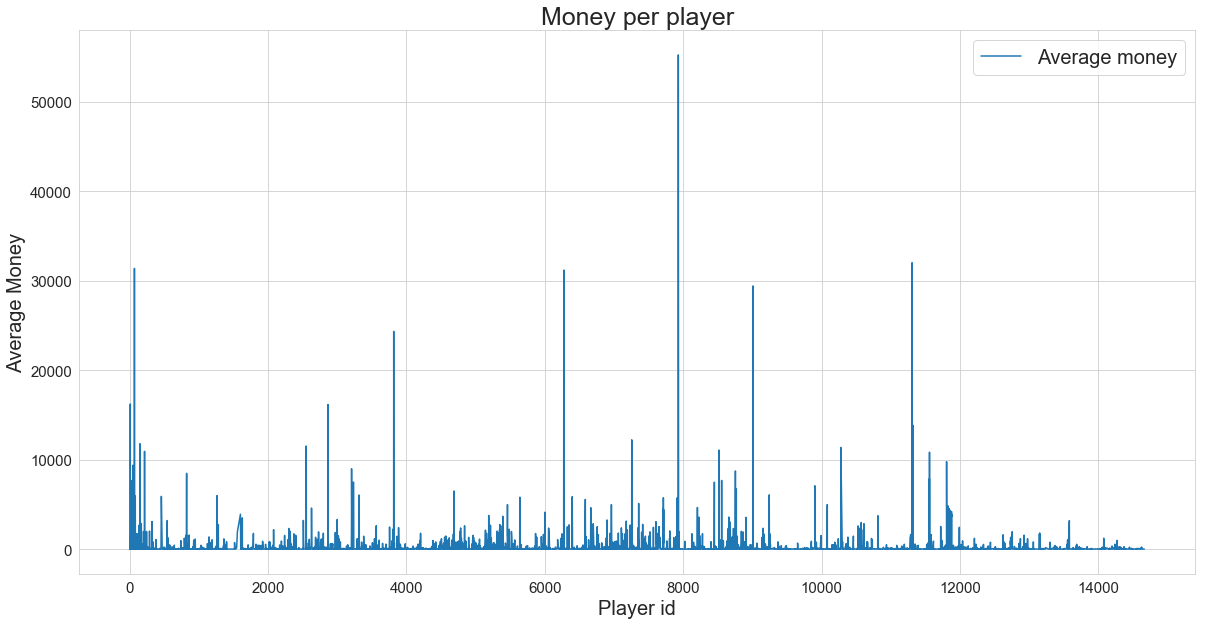

In [8]:
df_player = pd.DataFrame(data.groupby("challenger").mean()).reset_index()
df_player.rename(columns={"challenger": "player"}, inplace=True)
df_player = df_player[["player", "money"]]
df_player
df_opponent = pd.DataFrame(data.groupby("opponent").mean()).reset_index()
df_opponent.rename(columns={"opponent": "player"}, inplace=True)
df_opponent = df_opponent[["player", "money"]]
df_opponent
df_player = df_player.append(df_opponent).groupby("player").mean()
df_player = df_player.iloc[1:]  # remove player id = 0, since dummy for no race


fig, ax = plt.subplots(figsize=(20, 10))

df_player.plot(ax=ax)
plt.title("Money per player", fontsize=title_fontsize)
plt.xlabel("Player id", fontsize=axis_fontsize)
plt.ylabel("Average Money", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(["Average money"], prop={"size": legend_size})

plt.show()

The average money per player reflects reality ;-)

The wealth is accumulated by a few selected players! It is possible that they got bored and bet higher amounts of money.

## 3 Time
An interesting question might be if all players are living in the same time zone. To answer this we first group the races according to time of day, which we classified in 5 categories:
- morning (6 am - 1 pm)
- afternoon (12 am - 5 pm)
- evening (5 pm to 9 pm)
- early night (9 pm - 1 am)
- night (1 am - 6 am)

In [10]:
# Auxiliary function
def categorize_time_of_day(hour):

    online_times = {"morning": list(range(6, 13)),
                    "afternoon": list(range(12, 18)),
                    "evening": list(range(17, 22)),
                    "early_night": list(range(21, 24)) + [0, 1],
                    "night": list(range(1, 7))}

    if hour in online_times["morning"]:
        return "morning"
    elif hour in online_times["afternoon"]:
        return "afternoon"
    elif hour in online_times["evening"]:
        return "evening"
    elif hour in online_times["early_night"]:
        return "early_night"
    elif hour in online_times["night"]:
        return "night"

In [11]:
# Extract hours per player
df_challenger = pd.DataFrame(data.groupby("challenger").apply(lambda x: x.race_driven.dt.strftime("%H"))).reset_index(level=1, drop=True)
df_challenger.index.names = ["player_id"]
df_challenger.rename(columns={"race_driven": "hour"}, inplace=True)

df_opponent = pd.DataFrame(data.groupby("opponent").apply(lambda x: x.race_driven.dt.strftime("%H")).reset_index(level=1, drop=True))
df_opponent.rename(columns={"race_driven": "hour"}, inplace=True)
df_opponent.index.names = ["player_id"]

df_player = df_challenger.append(df_opponent)

# Count hours per player
df_player = pd.DataFrame(df_player.reset_index().groupby("player_id")["hour"].value_counts())
df_player.rename(columns={"hour": "games_per_hour"}, inplace=True)
df_player.reset_index(level=1, inplace=True)
df_player["hour"] = df_player["hour"].astype("int")

# Categorize time of day
df_player["time_of_day"] = df_player["hour"].apply(lambda x: categorize_time_of_day(x))

# Remove all players with only one race
df_player["total_games"] = df_player.groupby("player_id")["games_per_hour"].sum()
df_player = df_player.loc[df_player.total_games > 1]

# Compute fraction
df_player["fraction_games_per_hour"] = (df_player.loc[:,"games_per_hour"]/df_player.loc[:,"total_games"]).values

# Get maximum category for each player
df_player_aux = df_player.groupby(["player_id","time_of_day"])["fraction_games_per_hour"].sum().reset_index(level=1)
index_max_time_of_day = df_player_aux.groupby(["player_id"])["fraction_games_per_hour"].transform(max) == df_player_aux["fraction_games_per_hour"]
max_time_of_day = df_player_aux[index_max_time_of_day]

# Map back to df_player dataframe # TODO: really crappy code!
time_of_days = df_player["time_of_day"].unique()
df_player["max_time_of_day"] = time_of_days[0]
for day_time in time_of_days[1:]:
    df_player.loc[max_time_of_day.loc[max_time_of_day.time_of_day==day_time].index.unique(), "max_time_of_day"] = day_time

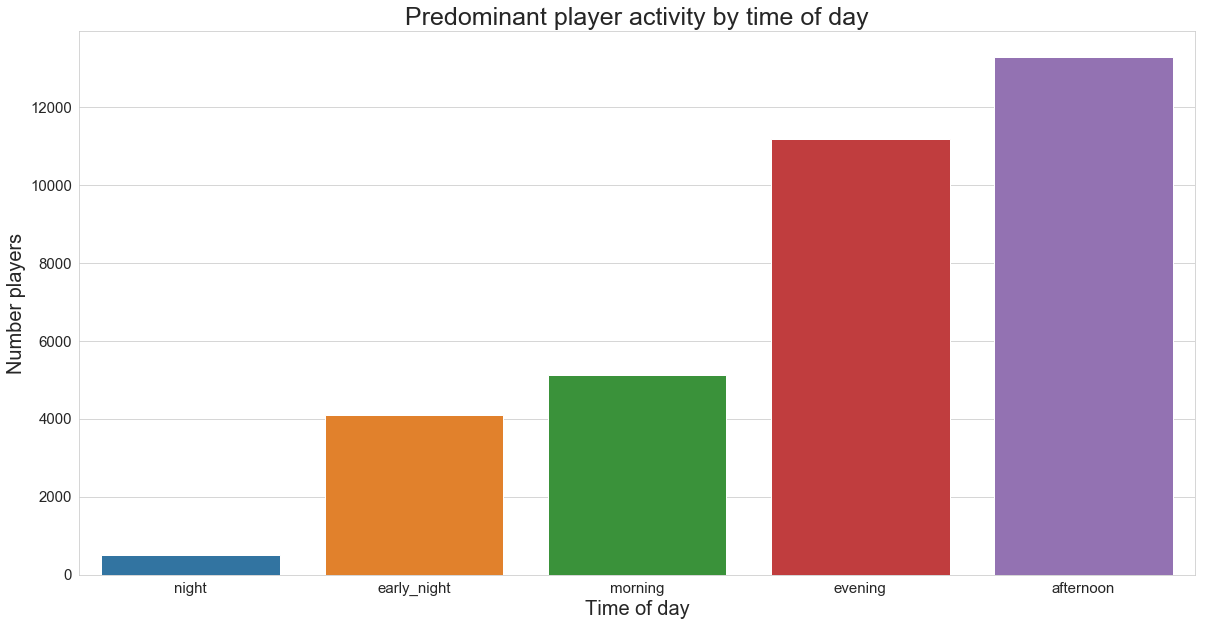

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=df_player.groupby("max_time_of_day").count().iloc[:, 0].sort_values().index,
            y=df_player.groupby("max_time_of_day").count().iloc[:, 0].sort_values().values,
            ax=ax)
plt.title("Predominant player activity by time of day", fontsize=title_fontsize)
plt.xlabel("Time of day", fontsize=axis_fontsize)
plt.ylabel("Number players", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

Clearly, most of the community is playing during afternoon and evening which is the expected behavior. Furthermore, we see a significant lower amount of players predominently playing during night time (and morning). Thus, we conclude that all players are living in the same time zone. If this would not be the case, then the boxplot would be more evenly distributed.

## 4 ELO
Lastly we visualize the change in ELO of the top 5 strongest players (with respect to the end of the time series).

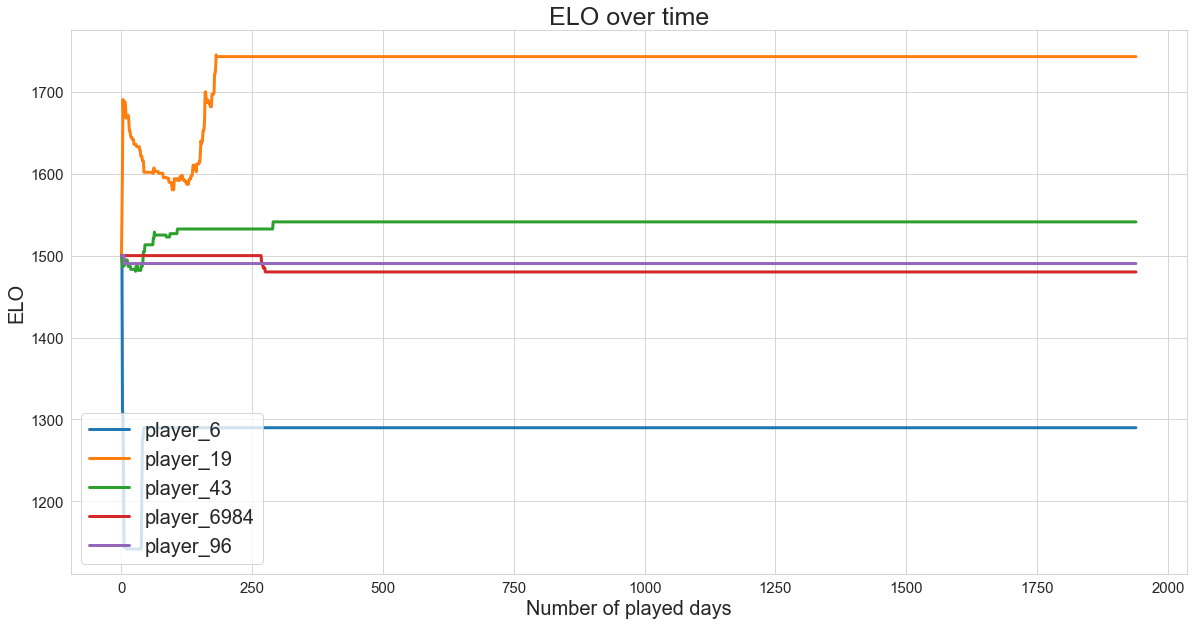

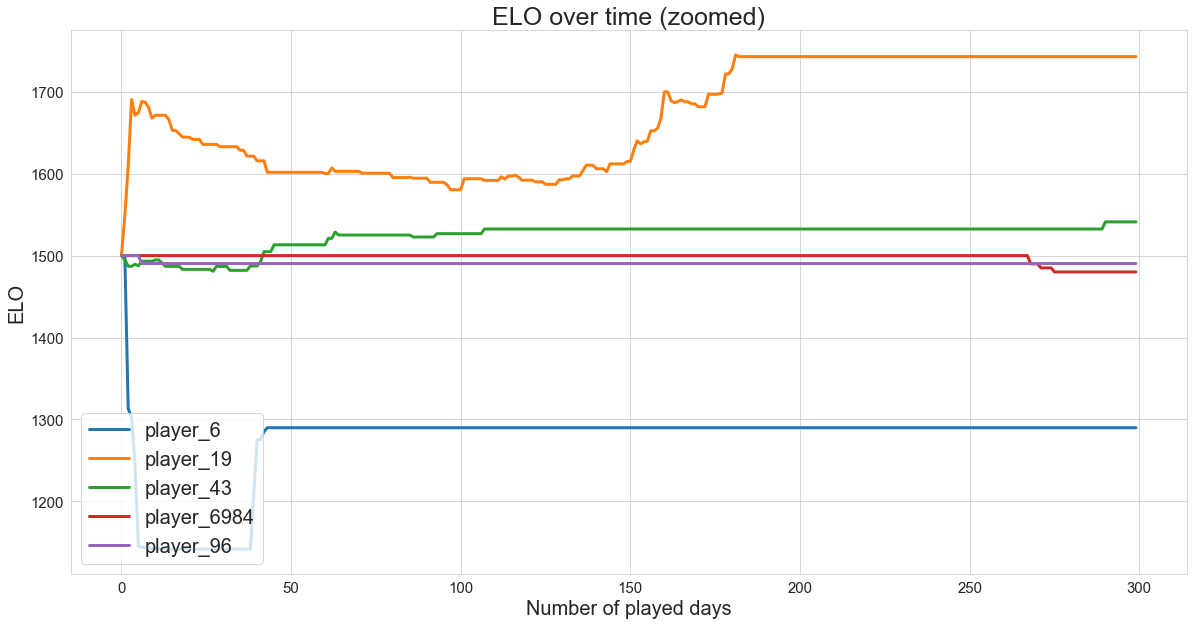

In [14]:
# Read data
top5_elo_df = pd.read_csv("data/processed_data/top5_elo.csv")

fig, ax = plt.subplots(figsize=(20, 10))

labels = top5_elo_df.columns
for i in range(5):
    sns.lineplot(x=top5_elo_df.index, y=top5_elo_df.iloc[:, i], label=labels[i], lw=3)
plt.title("ELO over time", fontsize=title_fontsize)
plt.xlabel("Number of played days", fontsize=axis_fontsize)
plt.ylabel("ELO", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(prop={"size": legend_size})

plt.show()

# Only up to day 300
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(5):
    sns.lineplot(x=top5_elo_df.index[:300], y=top5_elo_df.iloc[:300, i], label=labels[i], lw=3)
plt.title("ELO over time (zoomed)", fontsize=title_fontsize)
plt.xlabel("Number of played days", fontsize=axis_fontsize)
plt.ylabel("ELO", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(prop={"size": legend_size})

plt.show()

Apparently they all stopped playing after the initial high popularity phase (up to year XY). Even though they are the strongest players, none resumed playing at the short comeback in the summer of 201X. TODO We might speculate from this that there is no clear ranking system within the game, which might trigger a long term interest in the players (if they are highly ranked they should be more reluctant to stop playing, lest they loose their top position).